# Theory

Some of the rates related formulas are from Leif Andersen's 3-volume book. 

In [1]:
import IPython; IPython.display.HTML('''<script>code_show=false; function code_toggle() { if (code_show){ $('div.nbinput').show(); } else { $('div.nbinput').hide(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## [Copula](https://en.wikipedia.org/wiki/Copula_(probability_theory))

### Definition and Usage

* A $d$-dimensional copula is a CDF defined on $[0, 1]^d$ such that all marginal distributions are Uniform(0, 1)
* Sklar's theorem: Under regularity conditions, any multivariate CDF can be uniquely written in terms of its marginal CDFs and some copula
* Gauss copula in 2D is defined as
\begin{align*}
C_{\rho}(u, v) = \Phi_{\rho}(\Phi^{-1}(u), \Phi^{-1}(v)), 
\end{align*}
where $\Phi$ is the 1D standard normal CDF and $\Phi_{\rho}$ is the bivariate normal CDF with covariance matrix
\begin{align*}
\begin{bmatrix}
1 & \rho \\
\rho & 1 
\end{bmatrix}
\end{align*}
* The copula density is 
\begin{align*}
c_\rho(u, v) = \frac{\partial C_{\rho}}{\partial v\partial v}(u, v) = \frac{\phi_{\rho}(\Phi^{-1}(u), \Phi^{-1}(v))}{\phi(\Phi^{-1}(u))\phi(\Phi^{-1}(v))}, 
\end{align*}
where $\phi$ is the 1D standard normal PDF and $\phi_{\rho}$ is the bivariate normal PDF with the same covariance matrix
* The bivariate CDF 
\begin{align*}
C_{\rho}(F_x(x), F_y(y))
\end{align*}
has marginal CDFs $F_x, F_y$ and Gauss copula correlation $\rho$, and the corresponding PDF is 
\begin{align*}
c_{\rho}(F_x(x), F_y(y))f_X(x)f_Y(y)
\end{align*}

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


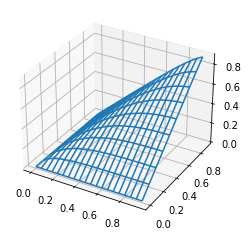

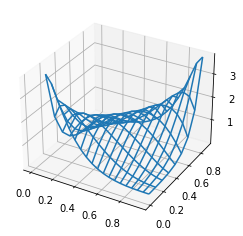

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from scipy.stats import norm, multivariate_normal

def C(u, v, rho):
    '''Bivariate Gauss copula'''
    return multivariate_normal.cdf([norm.ppf(u), norm.ppf(v)], cov=[[1.0, rho], [rho, 1.0]])

def c(u, v, rho):
    '''Bivariate Gauss copula density'''
    return multivariate_normal.pdf([norm.ppf(u), norm.ppf(v)], cov=[[1.0, rho], [rho, 1.0]])/(norm.pdf(norm.ppf(u))*norm.pdf(norm.ppf(v)))

def plot_surf(f, x, y, fillna=0):
    Z = np.array([[f(xi, yi) for xi in x] for yi in y])
    Z[np.isnan(Z)] = fillna
    X = np.array([x for _ in y])
    Y = np.array([y for _ in x]).T
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(X, Y, Z)
    
rho = 0.8
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.1)
plot_surf(lambda x, y: C(x, y, rho), x, y)
plot_surf(lambda x, y: c(x, y, rho), x, y, fillna=None)

In [11]:
from ipywidgets import interact

@interact(rho=(-0.9, 0.99, 0.1))
def f(rho=0.8):
    x = np.arange(0, 1, 0.05)
    y = np.arange(0, 1, 0.1)
    plot_surf(lambda x, y: C(x, y, rho), x, y)
    plot_surf(lambda x, y: c(x, y, rho), x, y, fillna=None)

interactive(children=(FloatSlider(value=0.8, description='rho', max=0.99, min=-0.9), Output()), _dom_classes=(…

### Simulation

* To simulate from Gauss copula: 
    1. generate normal random variables according to the covariance matrix
    1. plug every number into standard normal CDF so that the marginal distributions are uniform


* To simulate from a joint distribution such that the marginal distribution of $x, y$ are $\chi^2$ and exponential, respectively: 
    1. generate Gauss copula random numbers
    1. plug $x$ values into $\chi^2$ inverse CDF, and $y$ values into exponential inverse CDF
    

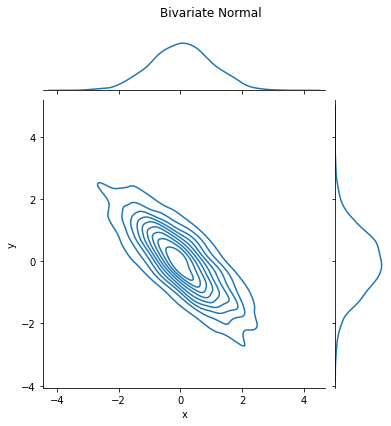

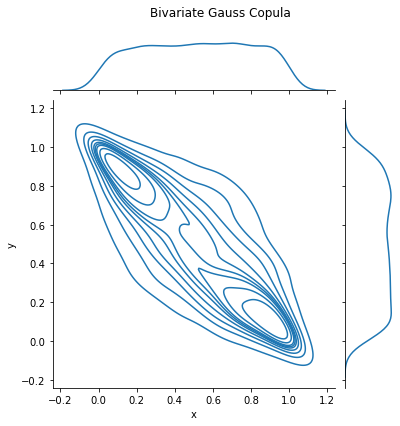

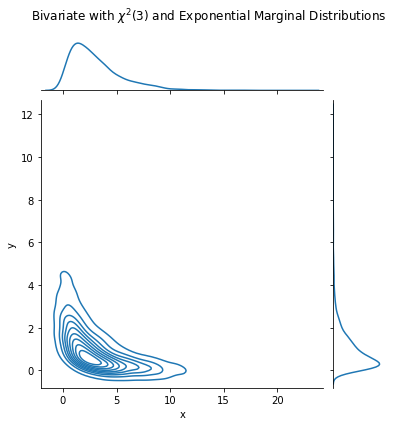

In [1]:
from scipy.stats import norm, multivariate_normal, chi2, expon
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_data(data, title):
    '''jointplot a DataFrame with 'x' and 'y' columns'''
    
    p = sns.jointplot(x='x', y='y', kind='kde', data=data)
    p.fig.suptitle(title)
    p.fig.subplots_adjust(top=0.9, right=0.9)

    
rho = -0.8
n = 2000

np.random.seed(0)
data = DataFrame(multivariate_normal(cov=[[1.0, rho], [rho, 1.0]]).rvs(n), columns=['x', 'y'])
plot_data(data=data, title='Bivariate Normal')

data = data.applymap(norm.cdf)
plot_data(data=data, title='Bivariate Gauss Copula')

data['x'] = data['x'].map(chi2(df=3).ppf)
data['y'] = data['y'].map(expon.ppf)
plot_data(data=data, title='Bivariate with $\chi^2(3)$ and Exponential Marginal Distributions')

## Notes on LMM

Let $q(t)$ be the index such that $T_{q(t)-1} \le t < T_{q(t)}$. Then the dynamics of the forward rate $L_n(t) = L(t, T_n, T_{n+1})$ in the spot measure $Q^B$ is
\begin{align*}
dL_n(t) = \sigma_n(t)^T\left(\sum_{j=q(t)}^n\frac{\tau_j\sigma_j(t)}{1+\tau_j L_j(t)} dt + dW^B(t)\right). 
\end{align*}
This is the discrete version of the HJM forward rate dynamics
\begin{align*}
df(t, T) = \sigma(t, T)^T \left(\Sigma(t, T)dt + d \widetilde W_t\right). 
\end{align*}
Adding stochastic volatility, the model is 
\begin{align*}
dz(t) &= \theta(1 - z(t))dt + \eta\sqrt{z(t)}dZ^B(t), \\
dL_n(t) &= \sqrt{z(t)}\phi(L_n(t))\lambda_n(t)^T\left(\sqrt{z(t)}\mu_n(t) dt + dW^B(t)\right), \\
\mu_n(t) &= \sum_{j=q(t)}^n\frac{\tau_j\phi(L_j(t))\lambda_j(t)}{1+\tau_j L_j(t)}. 
\end{align*}

## HW2F Summary

Let
\begin{align*}
h(t) &= \begin{bmatrix}
e^{-\kappa_1 t}\\
e^{-\kappa_2 t}
\end{bmatrix}_{2\times 1}, \\
g(t) &= \begin{bmatrix}
\sigma_1\sqrt{1-\rho^2} e^{\kappa_1 t} & 0\\
\sigma_1\rho e^{\kappa_1 t} & \sigma_2 e^{\kappa_2 t}
\end{bmatrix}_{2\times 2}. 
\end{align*}
The HJM forward rate vol is
\begin{align*}
\sigma(t, T) = g(t)h(T) = \begin{bmatrix}
\sigma_1\sqrt{1-\rho^2} e^{-\kappa_1 (T-t)} \\
\sigma_1\rho e^{-\kappa_1 (T-t)} + \sigma_2 e^{-\kappa_2 (T-t)}
\end{bmatrix}_{2\times 1}, 
\end{align*}
or, if allowing a correlation $\rho$ between the two Brownian motions in the forward rate process, 
\begin{align*}
\sigma^*(t, T) = \begin{bmatrix}
\sigma_1 e^{-\kappa_1 (T-t)} \\
\sigma_2 e^{-\kappa_2 (T-t)}
\end{bmatrix}_{2\times 1}. 
\end{align*}



Let $H(t) = \operatorname{diag}(h(t))$ and 
\begin{align*}
\sigma_x &= g(t)H(t) = \begin{bmatrix}
\sigma_1\sqrt{1-\rho^2} & 0\\
\sigma_1\rho & \sigma_2 
\end{bmatrix}_{2\times 2}, \\
\sigma_x^* &= \begin{bmatrix}
\sigma_1 & 0\\
0 & \sigma_2
\end{bmatrix}_{2\times 2}.
\end{align*}

Let 
\begin{align*}
\kappa &= \begin{bmatrix}
\kappa_1 & 0\\
0 & \kappa_2
\end{bmatrix}_{2\times 2}.
\end{align*}


Then the short rate process is $r(t) = f(0, t) + x_1(t) + x_2(t) = f(0, t) + x(t)\mathbf 1$, where $x(0) = y(0) = 0$, 
\begin{align*}
\begin{cases}
dx(t) = (y(t)\mathbf 1 - \kappa x(t))dt + \sigma_x^T dW(t)\\
dy(t) = (\sigma_x^T\sigma_x - \kappa y(t) - y(t)\kappa) dt \\
dW_1(t)dW_2(t) = 0
\end{cases}, 
\end{align*}
and the covariance matrix is 
\begin{align*}
\sigma_x^T\sigma_x = \begin{bmatrix}
\sigma_1^2 & \rho\sigma_1\sigma_2 \\
\rho\sigma_1\sigma_2 & \sigma_2^2
\end{bmatrix}_{2\times 2}.
\end{align*}
The ODE of $y(t)$ can be solved explicitly to obtain
\begin{align*}
y(t) &= H(t)\left(\int_0^t g(s)^Tg(s)\,ds\right)H(t)\\
&= \begin{bmatrix}
\frac{\sigma_1^2\left(1-e^{-2\kappa_1 t}\right)}{2\kappa_1} & \frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2}\\
\frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2} & \frac{\sigma_2^2\left(1-e^{-2\kappa_2 t}\right)}{2\kappa_2}
\end{bmatrix}_{2\times 2}.
\end{align*}
Alternatively, one can write
\begin{align*}
\begin{cases}
dx(t) = (y(t)\mathbf 1 - \kappa x(t))dt + \sigma^*_x dW^*(t) \\
dW_1^*(t)dW_2^*(t) = \rho dt
\end{cases}, 
\end{align*}
or more explicitly, 
\begin{align*}
\begin{cases}
dx_1(t) = \left(\frac{\sigma_1^2\left(1-e^{-2\kappa_1 t}\right)}{2\kappa_1} + \frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2} - \kappa_1 x_1(t)\right)dt + \sigma_1 dW^*_1(t) \\
dx_2(t) = \left(\frac{\sigma_2^2\left(1-e^{-2\kappa_2 t}\right)}{2\kappa_2} + \frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2} - \kappa_2 x_2(t)\right)dt + \sigma_2 dW^*_2(t) \\
dW_1^*(t)dW_2^*(t) = \rho dt
\end{cases}. 
\end{align*}




Let 
\begin{align*}
M(t, T) &= H(T)H(t)^{-1}\mathbf 1 = \begin{bmatrix}
e^{-\kappa_1(T-t)}\\
e^{-\kappa_2(T-t)}
\end{bmatrix}_{2\times 1}, \\
G(t, T) &= \int_t^TM(t, u)\,du = \begin{bmatrix}
\frac{1-e^{-\kappa_1(T-t)}}{\kappa_1}\\
\frac{1-e^{-\kappa_2(T-t)}}{\kappa_2}
\end{bmatrix}_{2\times 1}. 
\end{align*}
Then the forward rate process and the zero-coupon bond price are 
\begin{align*}
f(t, T) &= f(0, T) + M(t, T)^T(x(t) + y(t)G(t, T)), \\
P(t, T) &=\frac{P(0, T)}{P(0, t)}\exp\left(-G(t, T)^Tx(t) - \frac12G(t, T)^Ty(t)G(t, T)\right), 
\end{align*}
respectively. Note that since $G$ and $M$ are both functions of $T-t$, the dynamics of $f(t, T)$ and $P(t, T)$ are stationary. 


The risk-neutral process of $P(t, T)$ is log-normal
\begin{align*}
\frac{dP(t, T)}{P(t, T)} &= r(t)dt - (\sigma_x G(t, T))^T dW(t)\\
&= r(t)dt - (\sigma^*_x G(t, T))^T dW^*(t). 
\end{align*}
That is, the HJM bond price vol is $\Sigma(t, T) = \sigma_x G(t, T)$, or 
\begin{align*}
\Sigma^*(t, T) = \sigma^*_x G(t, T) = \begin{bmatrix}
\frac{\sigma_1}{\kappa_1}\left(1-e^{-\kappa_1(T-t)}\right)\\
\frac{\sigma_2}{\kappa_2}\left(1-e^{-\kappa_2(T-t)}\right)
\end{bmatrix}_{2\times 1}
\end{align*}
if allowing a correlation $\rho$ between the two Brownian motions in the process. 

## HW1F Summary

Let $h(t) = e^{-\kappa t}, g(t) = \sigma e^{\kappa t}$. 
The HJM forward rate vol is
\begin{align*}
\sigma(t, T) = g(t)h(T) = \sigma e^{-\kappa (T-t)}.
\end{align*}

The short rate process is $r(t) = f(0, t) + x(t)$, where $x(0) = y(0) = 0$, 
\begin{align*}
\begin{cases}
dx(t) = (y(t) - \kappa x(t))dt + \sigma dW(t)\\
dy(t) = (\sigma^2 - 2\kappa y(t)) dt
\end{cases}.
\end{align*}
The ODE of $y(t)$ can be solved explicitly to obtain
\begin{align*}
y(t) &= h^2(t)\int_0^t g^2(s)\,ds = \frac{\sigma^2\left(1-e^{-2\kappa t}\right)}{2\kappa}. 
\end{align*}
Let 
\begin{align*}
M(t, T) &= h(T)h(t)^{-1} = e^{-\kappa(T-t)}, \\
G(t, T) &= \int_t^TM(t, u)\,du = \frac{1-e^{-\kappa(T-t)}}{\kappa}.
\end{align*}
Then the forward rate process and the zero-coupon bond price are 
\begin{align*}
f(t, T) &= f(0, T) + M(t, T)(x(t) + y(t)G(t, T)), \\
P(t, T) &=\frac{P(0, T)}{P(0, t)}\exp\left(-G(t, T)x(t) - \frac12G^2(t, T)y(t)\right), 
\end{align*}
respectively. Note that since $G$ and $M$ are both functions of $T-t$, the dynamics of $f(t, T)$ and $P(t, T)$ are stationary. More explicitly, one can write $r(t) = f(0, t) + x(t)$, $x(0) = 0$, 
\begin{align*}
dx(t) &= \left(\frac{\sigma^2\left(1-e^{-2\kappa t}\right)}{2\kappa} - \kappa x(t)\right)dt + \sigma dW(t), \\
f(t, T) &= f(0, T) + e^{-\kappa(T-t)}\left(x(t) + \frac{\sigma^2\left(1-e^{-2\kappa t}\right)\left(1-e^{-\kappa(T-t)}\right)}{2\kappa^2}\right), \\
P(t, T) &=\frac{P(0, T)}{P(0, t)}\exp\left(-\frac{1-e^{-\kappa(T-t)}}{\kappa}x(t) - \frac{\sigma^2\left(1-e^{-2\kappa t}\right)\left(1-e^{-\kappa(T-t)}\right)^2}{4\kappa^3}\right). 
\end{align*}



The risk-neutral process of $P(t, T)$ is log-normal
\begin{align*}
\frac{dP(t, T)}{P(t, T)} &= r(t)dt - \sigma G(t, T) dW(t)\\
\end{align*}
That is, the HJM bond price vol is 
\begin{align*}
\Sigma(t, T) = \sigma G(t, T) = \frac{\sigma\left(1-e^{-\kappa(T-t)}\right)}{\kappa}.
\end{align*}


## Convolution Pricing

To simplify the argument, let $r=0$. Define
\begin{align*}
c(t, x) = E[Z|W_t = x] = E[Z|\mathcal F_t]
\end{align*}
to be the fair price of some derivative with payoff $Z$. Thus for $s < t$, we have
\begin{align*}
c(s, x) &= E[Z|W_s = x] = E[E[Z|\mathcal F_t]|\mathcal F_s]\\
&= E[c(t, W_t)|W_s = x].
\end{align*}
Now write $W_t = W_s + (W_t - W_s) = x + z$ and note that in $\mathcal F_s$, $z$ has a normal distribution $N(0, t-s)$. Thus 
\begin{align*}
c(s, x) &= \int_{-\infty}^{\infty} c(t, x+z) \frac{1}{\sqrt{2\pi(t-s)}} e^{-\frac{z^2}{2(t-s)}}\,dz\\
&= \int_{-\infty}^{\infty} c(t, y) \frac{1}{\sqrt{2\pi(t-s)}} e^{-\frac{(x-y)^2}{2(t-s)}}\,dz\\
&= c(t, x)\otimes p(x), 
\end{align*}
where $\otimes$ represents the convolution and $p(x)$ is the probability density function of $N(0, t-s)$. 

## SABR Normal Implied Volatility 

\begin{align*}
\begin{cases}
dF_t = \sigma_tF_t^{\beta}\,dW_t\\
d\sigma_t = \alpha \sigma_t\,dZ_t\\
dW_tdZ_t = \rho dt
\end{cases}
\end{align*}
* Code from [pysabr](https://github.com/ynouri/pysabr/blob/master/pysabr/models/hagan_2002_lognormal_sabr.py)，有和自己 implement 的 normal vol 對過結果一樣
* doc 上說 $\beta$ 和 $\rho$ 控制 IV skew，$\alpha$ 控制 IV convexity
* 實測 $\alpha$ 對 IV level 影響較大而不是 convexity
* 實測 $\beta$ 除了會改變 skew 之外也會影響 IV level，而且影響幅度遠大於 $\alpha$ 對 level 的影響
* $\rho$ 對 skew 的控制比 $\beta$ 效果明顯多了，所以 LMM 固定 $\rho=0$ 之後沒辦法 fit 任意 skew 

In [1]:
import numpy as np

def _f_minus_k_ratio(f, k, beta):
    """Hagan's 2002 f minus k ratio - formula (B.67a)."""
    eps = 1e-07  # Numerical tolerance for f-k and beta
    if abs(f-k) > eps:
        if abs(1-beta) > eps:
            return (1 - beta) * (f - k) / (f**(1-beta) - k**(1-beta))
        else:
            return (f - k) / np.log(f / k)
    else:
        return k**beta


def _zeta_over_x_of_zeta(k, f, t, alpha, beta, rho, volvol):
    """Hagan's 2002 zeta / x(zeta) function - formulas (B.67a)-(B.67b)."""
    eps = 1e-07  # Numerical tolerance for zeta
    f_av = np.sqrt(f * k)
    zeta = volvol * (f - k) / (alpha * f_av**beta)
    if abs(zeta) > eps:
        return zeta / _x(rho, zeta)
    else:
        # The ratio converges to 1 when zeta approaches 0
        return 1.


def _x(rho, z):
    """Hagan's 2002 x function - formula (B.67b)."""
    a = (1 - 2*rho*z + z**2)**.5 + z - rho
    b = 1 - rho
    return np.log(a / b)


def normal_vol(k, f, t, alpha, beta, rho, volvol):
    """Hagan's 2002 SABR normal vol expansion - formula (B.67a)."""
    # We break down the complex formula into simpler sub-components
    f_av = np.sqrt(f * k)
    A = - beta * (2 - beta) * alpha**2 / (24 * f_av**(2 - 2 * beta))
    B = rho * alpha * volvol * beta / (4 * f_av**(1 - beta))
    C = (2 - 3 * rho**2) * volvol**2 / 24
    FMKR = _f_minus_k_ratio(f, k, beta)
    ZXZ = _zeta_over_x_of_zeta(k, f, t, alpha, beta, rho, volvol)
    # Aggregate all components into actual formula (B.67a)
    v_n = alpha * FMKR * ZXZ * (1 + (A + B + C) * t)
    return v_n

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas import DataFrame 
from ipywidgets import interact

import warnings
warnings.filterwarnings('ignore')

@interact(F=(0.08, 0.15, 0.001), T=(1, 5, 1), alpha=(0.001, 0.01, 0.001), beta=(0.01, 0.99, 0.1), rho=(-0.99, 0.99, 0.1), volvol=(0.01, 1, 0.1))
def plot(F=0.1, T=1, alpha=0.01, beta=0.6, rho=0., volvol=0.6):
    a = 0.08
    b = 0.12
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    def call(K, F, T, A=1):
        iv = normal_vol(K, F, T, alpha, beta, rho, volvol)
        d = (F-K)/(iv*np.sqrt(T))
        return A*iv*np.sqrt(T)*(norm.pdf(d) + d*norm.cdf(d))
        
    def put(K, F, T, A=1):
        return call(K, F, T, A) + A*(K-F)
    
    DataFrame([(K, normal_vol(K, F, T, alpha, beta, rho, volvol)) for K in np.arange(a, b, 0.01)], columns=['K', 'Implied Vol']).set_index('K').plot(style='-.', legend=None, ax=ax1)
    ax1.set(ylim=(-0.001, 0.015), title='SABR Normal Implied Vol')
    
    DataFrame([(K, call(K, F, T) if K>F else put(K, F, T)) for K in np.arange(a, b, 0.001)], columns=['K', 'OTM Options']).set_index('K').plot(style='-.', legend=None, ax=ax2)
    ax2.set(ylim=(-0.0001, 0.0012), title='OTM Option PV')
    plt.show()


interactive(children=(FloatSlider(value=0.1, description='F', max=0.15, min=0.08, step=0.001), IntSlider(value…

## BM Quadratic Variation

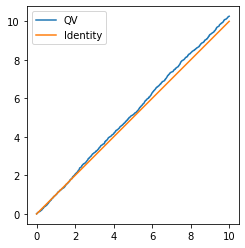

In [1]:
import numpy as np
from pandas import DataFrame

T = 10
n = 2500
dt = T/n

ax = DataFrame({'QV': (np.random.normal(0, np.sqrt(dt), n)**2).cumsum(), 
                'Identity': np.arange(dt, T+dt, dt)
               }, 
               index=np.arange(dt, T+dt, dt)).plot()
ax.set_aspect(1)


## SV Models

All models below are in the risk-neutral world and there can be a price-volatility correlation, meaning $dZ_tdW_t = \rho dt$.

![](../fig/sv.png)


From wikipedia: 
[SV Models](https://en.wikipedia.org/wiki/Stochastic_volatility), 
[CEV](https://en.wikipedia.org/wiki/Constant_elasticity_of_variance_model), 
[LV](https://en.wikipedia.org/wiki/Local_volatility), 
[SABR](https://en.wikipedia.org/wiki/SABR_volatility_model)


[GARCH(1, 1) limiting case derivation](https://math.berkeley.edu/~btw/thesis4.pdf)


MD 表 + 連結 + 數學符號 publish 之後會爛掉。這裡放的是圖。原本的 code 在下面被 comment out。圖其實可以不用存起來，直接 snipping tool 剪下之後在 cell 裡貼上就可以了

<!--
|Model| Dynamics | Speed Log Return QV Increase | Note
|--|--|--|--|
|[CEV](https://en.wikipedia.org/wiki/Constant_elasticity_of_variance_model)|$$dS_t = rS_t dt + \sigma S_t^{\beta} dW_t$$ | $$\sigma^2S_t^{2(\beta -1)}$$ | $$\beta< 1: \text{leverage effect; }\beta> 1: \text{inverse leverage effect}$$ |
|[LV](https://en.wikipedia.org/wiki/Local_volatility)| $$dS_t = rS_t dt + \sigma(t, S_t) S_t dW_t$$ | $$\sigma^2(t, S_t)$$ ||
|Heston|$$
\begin{cases}
dS_t = rS_tdt + \sqrt{V_t}S_t dW_t\\
dV_t = \theta(\kappa - V_t)dt + \sigma\sqrt{V_t} dZ_t
\end{cases}
$$| $$V_t$$ | $$V_t \text{ accumulates QV at the speed } \sigma^2 V_t$$ |
|[SABR](https://en.wikipedia.org/wiki/SABR_volatility_model)|$$
\begin{cases}
dF_t = \sigma_tF_t^{\beta} dW_t\\
d\sigma_t = \alpha\sigma_t dZ_t
\end{cases}
$$| $$\sigma_t^2F_t^{2(\beta -1)}$$ | $$\sigma_t \text{ accumulates QV at the speed } \alpha^2 \sigma_t^2$$ |
| GARCH(1, 1)|$$
dV_t = \theta(\kappa-V_t)dt + \sigma V_t dW_t
$$| $$?$$ | $$V_t \text{ accumulates QV at the speed } \sigma^2 V_t^2$$ Derivation of limiting case see [here](https://math.berkeley.edu/~btw/thesis4.pdf)|
-->

## Empirically...

* The log return of S&P 500 doesn't accumulate QV at a constant rate $\sigma^2$ per unit time as it's assumed in the Black-Scholes model
* The Heston model assumes that the log return accumulates QV at the rate of the volatility $V_t$, and the volatility accumulates QV at the rate of $\sigma^2 V_t$. So the speed the log return accumulates QV is a constant times the speed the volatility accumulates QV. 

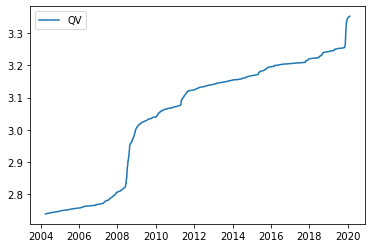

In [3]:
from pandas import DataFrame
import pandas as pd
import numpy as np

# data from 1928/1/1 - 2020/6/1

df = pd.read_csv('../data/^GSPC.csv').set_index('Date')
df = np.log(df[['Adj Close']].pct_change()[1:] + 1)

log_return = df.values

n = len(log_return)
dt = 1/252
ax = DataFrame({'QV': (log_return**2).cumsum()}, index=np.arange(dt+1928, (n+1)*dt+1928, dt)).tail(4000).plot()
# ax.set_aspect(1)



## [Penalty Method for American Put Pricing](https://cs.uwaterloo.ca/~paforsyt/con7.pdf)

\begin{align*}
V_{\tau} = \frac{\sigma^2S^2}{2}V_{SS} + rSV_S - rV + \rho\max(V^{*}-V, 0), 
\end{align*}
where $V^* = (K-S)^+$ is the payoff function, and $\rho$ is a large number. 

* Above the early exercise boundary, the penalty term disappears and the PDE reduces to the Black-Scholes PDE
* Below the boundary, the penalty term dominates and PDE is approximately $V_{\tau} = \rho(V^{*}-V)$ whose solution is $V = V^{*}$


## Formulas I Always Forget

### SABR Model
\begin{align*}
\begin{cases}
dF_t = \sigma_tF_t^{\beta}\,dW_t\\
d\sigma_t = \alpha \sigma_t\,dZ_t\\
\end{cases}
\end{align*}
兩個 Brownian motion 有相關性 $dW_tdZ_t = \rho dt$。這裡 $\alpha$ 是真的 vol of vol，不像 Heston 裡的 $\sigma$ 其實是 volatility of variance。

### ZCB to Forward Rate
\begin{align*}
f(t, T) = -\frac{\partial}{\partial T}\log P(t, T)
\end{align*}

### Ito Quotient Rule
\begin{align*}
\frac{d(X/Y)}{X/Y} = \frac{dX}{X} - \frac{dY}{Y} - \frac{dX}{X}\frac{dY}{Y} + \left(\frac{dY}{Y}\right)^2
\end{align*}

### Fibonacci Sequence
\begin{align*}
F_n = \frac{1}{\sqrt{5}}\left(\left(\frac{1+\sqrt{5}}{2}\right)^n - \left(\frac{1-\sqrt{5}}{2}\right)^n\right)
\end{align*}
CF 是 $x^2 - x - 1$ 所以 $b=-1$，兩根的分子的第一項一定是 1 而不是 -1。兩項中間的負號只要看 $F_0 = 0$ 就不會忘記了。

